# Preprocessing the original data

## Reading the data

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

isInKaggle = False
FILES_PATH = "/kaggle/input/store-sales-time-series-forecasting/" if isInKaggle else "D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/data/storeSalesTS/"
train = pd.read_csv(FILES_PATH+'train.csv')
test = pd.read_csv(FILES_PATH+'test.csv')
train.tail(3)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/data/storeSalesTS/train.csv'

In [2]:
test.head(3)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2


In [3]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

### Some results

In [4]:
train[(train['family']=='AUTOMOTIVE') & (train['store_nbr']==2)].head(5)

,id,date,store_nbr,family,sales,onpromotion
363,363,2013-01-01,2,AUTOMOTIVE,0.0,0
2145,2145,2013-01-02,2,AUTOMOTIVE,8.0,0
3927,3927,2013-01-03,2,AUTOMOTIVE,5.0,0
5709,5709,2013-01-04,2,AUTOMOTIVE,3.0,0
7491,7491,2013-01-05,2,AUTOMOTIVE,5.0,0


In [5]:
train['sales'].value_counts(sort=False)#.describe()

0.000       939130
2.000        85959
810.000        193
180.589          2
186.000       1157
             ...  
551.713          1
6630.383         1
438.133          1
154.553          1
2419.729         1
Name: sales, Length: 379610, dtype: int64

In [6]:
#Each family has the same number of stores of the remainig ones ...
train['store_nbr'].value_counts(sort=False).describe()
# train['family'].value_counts(sort=False)
# train['date'].value_counts(sort=False).describe()


count       54.0
mean     55572.0
std          0.0
min      55572.0
25%      55572.0
50%      55572.0
75%      55572.0
max      55572.0
Name: store_nbr, dtype: float64

<AxesSubplot:title={'center':'sales'}, xlabel='date'>

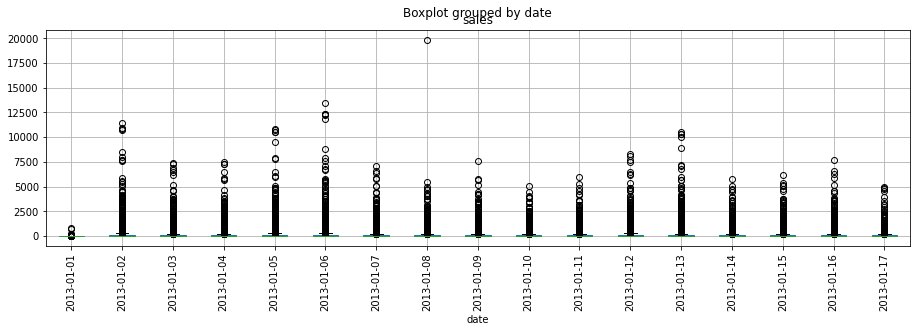

In [7]:
train[:round(.01*train.shape[0])].boxplot(column='sales', by='date', rot = 90, figsize=(15, 4))
# plt.show();

<AxesSubplot:title={'center':'l_sales'}, xlabel='date'>

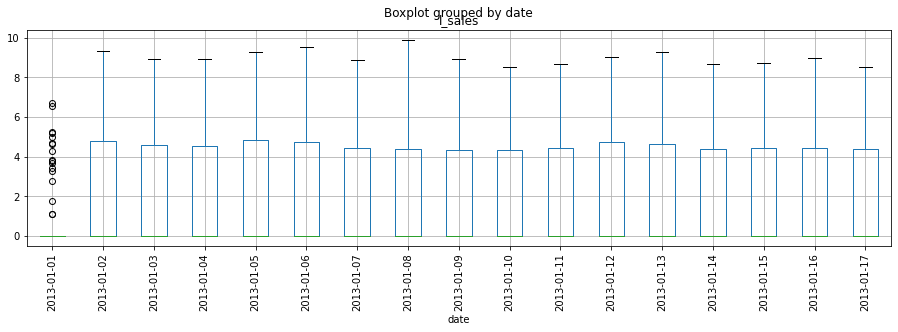

In [8]:
train['l_sales'] = np.log1p(train['sales'])
train[:round(.01*train.shape[0])].boxplot(column='l_sales', by='date', rot = 90, figsize=(15, 4))

## Converting the original data into Time Series (TS)

In [9]:
#Computing time series data set
#print(train.dtypes)
def getCategories(varName, dataFrame):
    labels = dataFrame[varName].value_counts().reset_index(
            name='Freq').rename(columns={'index': varName}).sort_values(by=varName)
    labels = labels[varName].tolist()
    print("********** " + varName + " **********")
    print("length = ", len(labels))
    print(labels[:2], ' ... ', labels[len(labels)-2:])
    return(labels)
dates = getCategories(varName = 'date', dataFrame = train)
families = getCategories(varName = 'family', dataFrame = train)
stores = getCategories(varName = 'store_nbr', dataFrame = train)
print('>>> We have a total of '+ str(len(families)*len(stores)) + ' time series (TS), each one with '+ 
str(len(dates)) + ' observations in the train set.')

********** date **********
length =  1684
['2013-01-01', '2013-01-02']  ...  ['2017-08-14', '2017-08-15']
********** family **********
length =  33
['AUTOMOTIVE', 'BABY CARE']  ...  ['SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
********** store_nbr **********
length =  54
[1, 2]  ...  [53, 54]
>>> We have a total of 1782 time series (TS), each one with 1684 observations in the train set.


### MORE EFFICIENT AND RELIABLE METHOD FOR TS COMPUTATION

In [10]:

from csv import writer
def computeTimeSeries(idRelatedDataFrame, outputFilePath):
    df = idRelatedDataFrame
    colNames = []
    n = 2
    dates = getCategories(varName = 'date', dataFrame = idRelatedDataFrame)
    print('>>> from ' + dates[0] + ' to ' + dates[len(dates)-1] + " <<< ") 
    isToAppendColNames = False
    startDateIndex = 0
    try:
        data =pd.read_csv(outputFilePath, encoding='ISO-8859-1')#it will work if the file exists
        startDateIndex = len(data)
    except:
        isToAppendColNames = True
    inc = startDateIndex
    with open(outputFilePath,'a') as fd:
        csv_writer = writer(fd)
        for t in dates[startDateIndex:]:#(n+startDateIndex+1)]:
            inc = inc + 1
            if(isToAppendColNames == True):
                colNames.append('date')
            row_t = []
            row_t.append(t)
            for f in families:#[:n]:
                for s in stores:#[:n]:
                    data_tfs = df[(df['date']==t) & (df['family']==f) & (df['store_nbr']==s)]
                    # print('data_tfs: ', data_tfs)
                    fs = f+"_"+str(s)
                    fs_id = fs+"_id"
                    fs_sales = fs+'_sales'
                    fs_onpromotion = fs+'_onpromotion'
                    if(isToAppendColNames == True):
                        colNames.append(fs_id)
                        if(idRelatedDataFrame is train):
                            colNames.append(fs_sales)
                        colNames.append(fs_onpromotion)
                    # print("data_tfs['id']: ", data_tfs['id'].tolist())
                    row_t.append(int(data_tfs['id']))
                    if(idRelatedDataFrame is train):
                        row_t.append(float(data_tfs['sales']))
                    row_t.append(int(data_tfs['onpromotion']))
    #         print(row_t)
            if(isToAppendColNames == True):
                isToAppendColNames = False
                csv_writer.writerow(colNames)
            csv_writer.writerow(row_t)
            print(t + " is done -> " + str(round(100*inc/len(dates), 2)) + "%")
    ret = pd.read_csv(outputFilePath)
    print('>>> Time Series computation complited!!')
    return(ret)

ts_train_validation = computeTimeSeries(idRelatedDataFrame = train, outputFilePath = "../data/storeSalesTS/train_storeSales_TS.csv")
ts_test = computeTimeSeries(idRelatedDataFrame = test, outputFilePath = "../data/storeSalesTS/test_storeSales_TS.csv")
print('ts_train_validation.shape = ', ts_train_validation.shape)
print('ts_test.shape = ', ts_test.shape)
print('********** ts_train_validation head **********')
ts_train_validation.head(5)

********** date **********
length =  1684
['2013-01-01', '2013-01-02']  ...  ['2017-08-14', '2017-08-15']
>>> from 2013-01-01 to 2017-08-15 <<< 
>>> Time Series computation complited!!
********** date **********
length =  16
['2017-08-16', '2017-08-17']  ...  ['2017-08-30', '2017-08-31']
>>> from 2017-08-16 to 2017-08-31 <<< 
>>> Time Series computation complited!!
ts_train_validation.shape =  (1684, 5347)
ts_test.shape =  (16, 3565)
********** ts_train_validation head **********


,date,AUTOMOTIVE_1_id,AUTOMOTIVE_1_sales,AUTOMOTIVE_1_onpromotion,AUTOMOTIVE_2_id,AUTOMOTIVE_2_sales,AUTOMOTIVE_2_onpromotion,AUTOMOTIVE_3_id,AUTOMOTIVE_3_sales,AUTOMOTIVE_3_onpromotion,...,SEAFOOD_51_onpromotion,SEAFOOD_52_id,SEAFOOD_52_sales,SEAFOOD_52_onpromotion,SEAFOOD_53_id,SEAFOOD_53_sales,SEAFOOD_53_onpromotion,SEAFOOD_54_id,SEAFOOD_54_sales,SEAFOOD_54_onpromotion
0,2013-01-01,0,0.0,0,363,0.0,0,726,0.0,0,...,0,1583,0.0,0,1616,0.0,0,1649,0.0,0
1,2013-01-02,1782,2.0,0,2145,8.0,0,2508,10.0,0,...,0,3365,0.0,0,3398,0.0,0,3431,3.0,0
2,2013-01-03,3564,3.0,0,3927,5.0,0,4290,7.0,0,...,0,5147,0.0,0,5180,0.0,0,5213,2.0,0
3,2013-01-04,5346,3.0,0,5709,3.0,0,6072,3.0,0,...,0,6929,0.0,0,6962,0.0,0,6995,2.0,0
4,2013-01-05,7128,5.0,0,7491,5.0,0,7854,12.0,0,...,0,8711,0.0,0,8744,0.0,0,8777,1.0,0


In [11]:
print('>>> We have ', str(len(families)*len(stores)), " time series. One for each combination of 'family' and 'store_nbr'.\n",
      len(ts_train_validation), ' rows (days) in the training/validation set, and \n',
      len(ts_test), ' rows (days) in the test set. Thus, the models must forecast ', 
      len(ts_test), ' steps (days) ahead!')
ts_test.head(len(ts_test))

>>> We have  1782  time series. One for each combination of 'family' and 'store_nbr'.
 1684  rows (days) in the training/validation set, and 
 16  rows (days) in the test set. Thus, the models must forecast  16  steps (days) ahead!


,date,AUTOMOTIVE_1_id,AUTOMOTIVE_1_onpromotion,AUTOMOTIVE_2_id,AUTOMOTIVE_2_onpromotion,AUTOMOTIVE_3_id,AUTOMOTIVE_3_onpromotion,AUTOMOTIVE_4_id,AUTOMOTIVE_4_onpromotion,AUTOMOTIVE_5_id,...,SEAFOOD_50_id,SEAFOOD_50_onpromotion,SEAFOOD_51_id,SEAFOOD_51_onpromotion,SEAFOOD_52_id,SEAFOOD_52_onpromotion,SEAFOOD_53_id,SEAFOOD_53_onpromotion,SEAFOOD_54_id,SEAFOOD_54_onpromotion
0,2017-08-16,3000888,0,3001251,0,3001614,0,3001977,0,3002340,...,3002405,0,3002438,0,3002471,0,3002504,0,3002537,0
1,2017-08-17,3002670,0,3003033,0,3003396,0,3003759,0,3004122,...,3004187,0,3004220,0,3004253,0,3004286,0,3004319,0
2,2017-08-18,3004452,0,3004815,0,3005178,0,3005541,0,3005904,...,3005969,4,3006002,6,3006035,3,3006068,1,3006101,0
3,2017-08-19,3006234,0,3006597,0,3006960,0,3007323,0,3007686,...,3007751,0,3007784,0,3007817,0,3007850,0,3007883,1
4,2017-08-20,3008016,0,3008379,0,3008742,0,3009105,0,3009468,...,3009533,0,3009566,0,3009599,0,3009632,0,3009665,0
5,2017-08-21,3009798,0,3010161,0,3010524,0,3010887,0,3011250,...,3011315,0,3011348,0,3011381,0,3011414,0,3011447,0
6,2017-08-22,3011580,0,3011943,0,3012306,0,3012669,0,3013032,...,3013097,0,3013130,0,3013163,0,3013196,0,3013229,0
7,2017-08-23,3013362,0,3013725,0,3014088,0,3014451,0,3014814,...,3014879,0,3014912,1,3014945,1,3014978,0,3015011,0
8,2017-08-24,3015144,0,3015507,0,3015870,0,3016233,0,3016596,...,3016661,1,3016694,1,3016727,0,3016760,0,3016793,0
9,2017-08-25,3016926,0,3017289,0,3017652,0,3018015,0,3018378,...,3018443,4,3018476,4,3018509,3,3018542,2,3018575,0


# Preprocessing Time Series

## Preliminaries

### Appending the daily sales and onpromotion means to `ts_train_validation`

In [12]:
# daily_sales = train.groupby('date', as_index=False)['sales'].median()
aggregatedVarNm = 'sales_m'
ts_train_validation[aggregatedVarNm] = train.sort_values(by = 'date').groupby('date', as_index=False)['sales'].mean()['sales']
# store_daily_sales = train.groupby(['store_nbr', 'date'], as_index=False)['sales'].sum()
# item_daily_sales = train.groupby(['family', 'date'], as_index=False)['sales'].sum()
ts_train_validation[aggregatedVarNm].describe()

count    1684.000000
mean      357.775749
std       131.543347
min         1.409438
25%       248.435178
50%       354.763672
75%       441.046847
max       821.034771
Name: sales_m, dtype: float64

In [13]:
ts_train_validation['onpromotion_m'] = train.sort_values(by = 'date').groupby('date', as_index=False)['onpromotion'].mean()['onpromotion']
# store_daily_sales = train.groupby(['store_nbr', 'date'], as_index=False)['sales'].sum()
# item_daily_sales = train.groupby(['family', 'date'], as_index=False)['sales'].sum()
ts_train_validation['onpromotion_m'].describe()

count    1684.000000
mean        2.602770
std         3.040750
min         0.000000
25%         0.000000
50%         1.290685
75%         4.712262
max        15.073513
Name: onpromotion_m, dtype: float64

### considering `date` column as date time and the index

In [14]:
def setDateAsIndexAndDatetime (df):
    try:
        df.set_index('date', inplace=True)
    except Exception:
        pass
    df.index = pd.to_datetime(df.index)
setDateAsIndexAndDatetime (ts_train_validation)
setDateAsIndexAndDatetime (ts_test)


In [15]:
ts_train_validation.head(2)

,AUTOMOTIVE_1_id,AUTOMOTIVE_1_sales,AUTOMOTIVE_1_onpromotion,AUTOMOTIVE_2_id,AUTOMOTIVE_2_sales,AUTOMOTIVE_2_onpromotion,AUTOMOTIVE_3_id,AUTOMOTIVE_3_sales,AUTOMOTIVE_3_onpromotion,AUTOMOTIVE_4_id,...,SEAFOOD_52_sales,SEAFOOD_52_onpromotion,SEAFOOD_53_id,SEAFOOD_53_sales,SEAFOOD_53_onpromotion,SEAFOOD_54_id,SEAFOOD_54_sales,SEAFOOD_54_onpromotion,sales_m,onpromotion_m
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,0.0,0,363,0.0,0,726,0.0,0,1089,...,0.0,0,1616,0.0,0,1649,0.0,0,1.409438,0.0
2013-01-02,1782,2.0,0,2145,8.0,0,2508,10.0,0,2871,...,0.0,0,3398,0.0,0,3431,3.0,0,278.390807,0.0


### Taking the label of the target variables

In [16]:
targetsNms = [salesColumn for salesColumn in ts_train_validation.columns if '_sales' in salesColumn]
nTargets = len(targetsNms) #2#you can increase nTargets if you wish
targetsNms = targetsNms[:nTargets]
print('nTargets = ', nTargets)
print('some targets: ', targetsNms[50:60])

nTargets =  1782
some targets:  ['AUTOMOTIVE_51_sales', 'AUTOMOTIVE_52_sales', 'AUTOMOTIVE_53_sales', 'AUTOMOTIVE_54_sales', 'BABY CARE_1_sales', 'BABY CARE_2_sales', 'BABY CARE_3_sales', 'BABY CARE_4_sales', 'BABY CARE_5_sales', 'BABY CARE_6_sales']


### Initial graphics

In [17]:
# !pip install chart-studio
# !pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
# import xgboost as xgb
# import chart_studio.plotly as py
# import chart_studio.graph_objs as go
# from chart_studio.offline import init_notebook_mode, iplot
plt.style.use('fivethirtyeight')
color_palette = sns.color_palette()

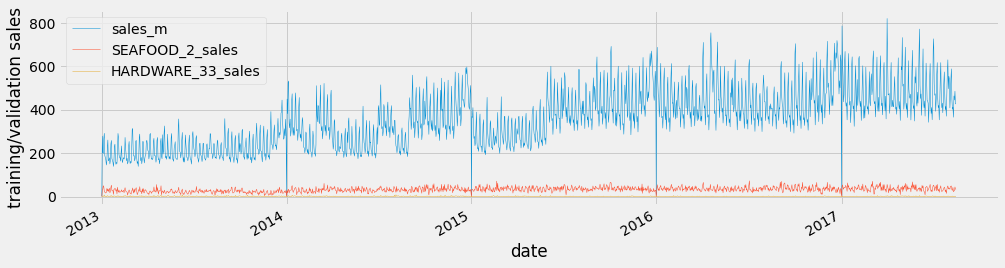

,AUTOMOTIVE_1_id,AUTOMOTIVE_1_sales,AUTOMOTIVE_1_onpromotion,AUTOMOTIVE_2_id,AUTOMOTIVE_2_sales,AUTOMOTIVE_2_onpromotion,AUTOMOTIVE_3_id,AUTOMOTIVE_3_sales,AUTOMOTIVE_3_onpromotion,AUTOMOTIVE_4_id,...,SEAFOOD_52_sales,SEAFOOD_52_onpromotion,SEAFOOD_53_id,SEAFOOD_53_sales,SEAFOOD_53_onpromotion,SEAFOOD_54_id,SEAFOOD_54_sales,SEAFOOD_54_onpromotion,sales_m,onpromotion_m
date,,,,,,,,,,,,,,,,,,,,,
2017-08-11,2991978,1.0,0,2992341,14.0,0,2992704,10.0,0,2993067,...,23.000,3,2993594,8.0,4,2993627,0.0,0,463.733851,7.956790
2017-08-12,2993760,6.0,0,2994123,7.0,0,2994486,9.0,0,2994849,...,5.000,0,2995376,6.0,0,2995409,1.0,1,444.798280,4.664422
2017-08-13,2995542,1.0,0,2995905,9.0,0,2996268,15.0,0,2996631,...,12.000,0,2997158,9.0,0,2997191,2.0,0,485.768618,5.209315
2017-08-14,2997324,1.0,0,2997687,4.0,0,2998050,7.0,0,2998413,...,6.595,0,2998940,9.0,0,2998973,0.0,0,427.004717,4.513468
2017-08-15,2999106,4.0,0,2999469,2.0,0,2999832,12.0,0,3000195,...,7.000,0,3000722,5.0,0,3000755,3.0,0,427.980884,5.951178


In [18]:
nTrialTargets = 2
random.seed(0)
trialTargetsNms = [aggregatedVarNm]+random.sample(targetsNms, nTrialTargets)#some study cases
ts_train_validation[trialTargetsNms].plot(style='-',
                                          figsize=(15, 4),
                                          color=color_palette[:len(
                                              trialTargetsNms)],
                                          ylabel='training/validation sales',
                                          legend=trialTargetsNms,
                                          linewidth=.5)
plt.show()
ts_train_validation.tail()

In [19]:
# Time series range
print("train/validation begin date: ", ts_train_validation.index[0])
print("train/validation end date: ", ts_train_validation.index[len(ts_train_validation)-1])
print("test begin date: ", ts_test.index[0])
print("test end date: ", ts_test.index[len(ts_test)-1])
# As one has a daily TS, there is no need to imput missing values between the train end date and test bgin date

train/validation begin date:  2013-01-01 00:00:00
train/validation end date:  2017-08-15 00:00:00
test begin date:  2017-08-16 00:00:00
test end date:  2017-08-31 00:00:00


## Preventing tendency, heterogeneity, and outliers in the target time series
Some times, there is tendency and heterogeneity in the time series. It will difficult the modeling and forecasting. To prevent these problems, one can apply the logarithm and then the difference on the log-series:

### Apllying log(y_t+1) tranformation

In [20]:
#https://scikit-learn.org/stable/modules/preprocessing.html
import numpy as np
from sklearn.preprocessing import FunctionTransformer
l_targetsNms = [('l_' + targetNm) for targetNm in targetsNms]
print('Some l_targetsNms:', l_targetsNms[:5])
log1pTransformer = FunctionTransformer(np.log1p, validate=True)#log(1+y_t)
l_ts_train_validation = pd.DataFrame(log1pTransformer.transform(ts_train_validation[targetsNms]),
                                        columns = l_targetsNms, index = ts_train_validation.index)
l_ts_train_validation.to_csv("../data/storeSalesTS/l_ts_train_validation.csv")
#to tranrform back to the original scale of the variables, one can use np.expm1(ly_t)
l_ts_train_validation.tail(3)


Some l_targetsNms: ['l_AUTOMOTIVE_1_sales', 'l_AUTOMOTIVE_2_sales', 'l_AUTOMOTIVE_3_sales', 'l_AUTOMOTIVE_4_sales', 'l_AUTOMOTIVE_5_sales']


C:\Users\praf6\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


,l_AUTOMOTIVE_1_sales,l_AUTOMOTIVE_2_sales,l_AUTOMOTIVE_3_sales,l_AUTOMOTIVE_4_sales,l_AUTOMOTIVE_5_sales,l_AUTOMOTIVE_6_sales,l_AUTOMOTIVE_7_sales,l_AUTOMOTIVE_8_sales,l_AUTOMOTIVE_9_sales,l_AUTOMOTIVE_10_sales,...,l_SEAFOOD_45_sales,l_SEAFOOD_46_sales,l_SEAFOOD_47_sales,l_SEAFOOD_48_sales,l_SEAFOOD_49_sales,l_SEAFOOD_50_sales,l_SEAFOOD_51_sales,l_SEAFOOD_52_sales,l_SEAFOOD_53_sales,l_SEAFOOD_54_sales
date,,,,,,,,,,,,,,,,,,,,,
2017-08-13,0.693147,2.302585,2.772589,1.945910,2.772589,2.484907,1.386294,1.098612,2.772589,0.000000,...,4.612692,4.109200,4.315873,3.611053,4.371610,3.750139,3.712718,2.564949,2.302585,1.098612
2017-08-14,0.693147,1.609438,2.079442,1.098612,1.945910,2.397895,1.386294,1.945910,2.197225,0.693147,...,4.387188,3.801360,4.248295,3.059693,4.392373,2.583394,3.751479,2.027490,2.302585,0.000000
2017-08-15,1.609438,1.098612,2.564949,2.079442,2.302585,2.079442,1.791759,1.609438,2.772589,1.609438,...,4.417454,3.896239,4.200505,3.032643,4.057715,2.792024,3.986685,2.079442,1.791759,1.386294


for AUTOMOTIVE_1_sales[0] = 1:  0.6931471805599453
for AUTOMOTIVE_2_sales[0] = 14:  2.70805020110221


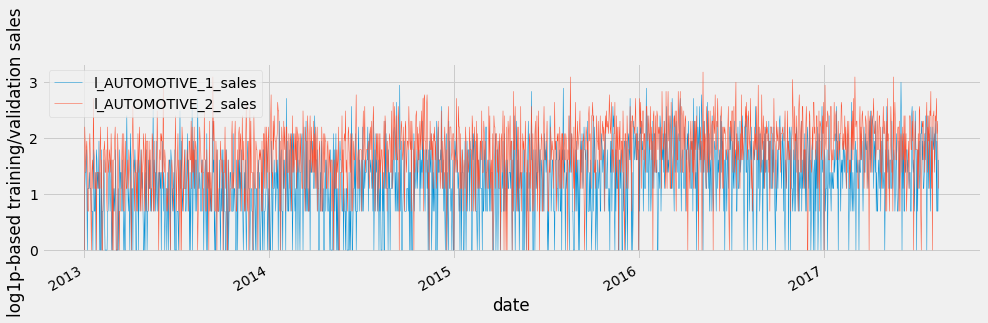

In [21]:
print('for AUTOMOTIVE_1_sales[0] = 1: ', np.log(1+1))
print('for AUTOMOTIVE_2_sales[0] = 14: ', np.log(14+1))
l_ts_train_validation[l_targetsNms[:2]].plot(style='-',
                                          figsize=(15, 4),
                                          color=color_palette[:2],
                                          ylabel='log1p-based training/validation sales',
                                          legend=l_targetsNms[:2],
                                          linewidth=.5)
plt.show()


### Apllying a first-order difference to the log-based series

In [22]:
dl_targetsNms = [('dl_' + targetNm) for targetNm in targetsNms]
# print('Some dl_targetsNms:', dl_targetsNms[:5])
dl_ts_train_validation = l_ts_train_validation.diff()
dl_ts_train_validation.columns=dl_targetsNms
dl_ts_train_validation.fillna(inplace=True, method='backfill')
dl_ts_train_validation.head(3)

,dl_AUTOMOTIVE_1_sales,dl_AUTOMOTIVE_2_sales,dl_AUTOMOTIVE_3_sales,dl_AUTOMOTIVE_4_sales,dl_AUTOMOTIVE_5_sales,dl_AUTOMOTIVE_6_sales,dl_AUTOMOTIVE_7_sales,dl_AUTOMOTIVE_8_sales,dl_AUTOMOTIVE_9_sales,dl_AUTOMOTIVE_10_sales,...,dl_SEAFOOD_45_sales,dl_SEAFOOD_46_sales,dl_SEAFOOD_47_sales,dl_SEAFOOD_48_sales,dl_SEAFOOD_49_sales,dl_SEAFOOD_50_sales,dl_SEAFOOD_51_sales,dl_SEAFOOD_52_sales,dl_SEAFOOD_53_sales,dl_SEAFOOD_54_sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.098612,2.197225,2.397895,2.564949,1.945910,1.386294,2.197225,2.079442,1.791759,1.386294,...,4.668558,4.259605,5.078406,3.641814,4.270788,3.767367,4.593108,0.0,0.0,1.386294
2013-01-02,1.098612,2.197225,2.397895,2.564949,1.945910,1.386294,2.197225,2.079442,1.791759,1.386294,...,4.668558,4.259605,5.078406,3.641814,4.270788,3.767367,4.593108,0.0,0.0,1.386294
2013-01-03,0.287682,-0.405465,-0.318454,-1.178655,-0.336472,-0.287682,-0.810930,-1.386294,1.343735,-0.287682,...,-1.030972,-0.363427,-0.622235,-0.187929,-0.204260,-0.466101,-0.417767,0.0,0.0,-0.287682


dl for AUTOMOTIVE_1_sales at 2017-08-15: 0.916291


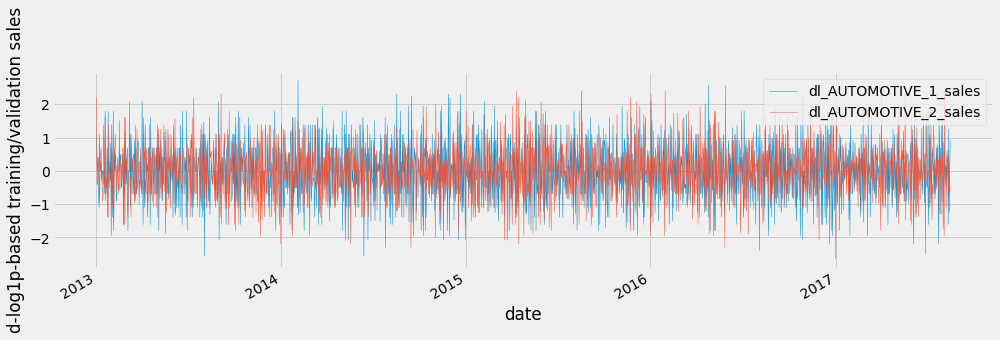

In [23]:
print('dl for AUTOMOTIVE_1_sales at 2017-08-15:', str(1.609438-0.693147))
dl_ts_train_validation[dl_targetsNms[:2]].plot(style='-',
                                          figsize=(15, 4),
                                          color=color_palette[:2],
                                          ylabel='d-log1p-based training/validation sales',
                                          legend=dl_targetsNms[:2],
                                          linewidth=.5)
plt.show()


### Standardizing the `d-log1p` target time series (`d_targetsNms`)

In [24]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
import joblib
zdl_scaler = StandardScaler()
zdl_scaler.fit(dl_ts_train_validation)
joblib.dump(zdl_scaler, '../results/storeSalesTS/zdl_scaler.joblib', compress=3)
zdl_targetsNms = [('zdl_' + targetNm) for targetNm in targetsNms]

print(dl_targetsNms[:2], 'mean and std:')
print('means: ', zdl_scaler.mean_[:2])
print('stds: ', zdl_scaler.scale_[:2])

zdl_ts_train_validation = pd.DataFrame(zdl_scaler.transform(dl_ts_train_validation), 
                        columns= zdl_targetsNms, 
                        index = ts_train_validation.index)
zdl_ts_train_validation.head(3)

['dl_AUTOMOTIVE_1_sales', 'dl_AUTOMOTIVE_2_sales'] mean and std:
means:  [0.00160811 0.00195715]
stds:  [0.89710881 0.79607922]


,zdl_AUTOMOTIVE_1_sales,zdl_AUTOMOTIVE_2_sales,zdl_AUTOMOTIVE_3_sales,zdl_AUTOMOTIVE_4_sales,zdl_AUTOMOTIVE_5_sales,zdl_AUTOMOTIVE_6_sales,zdl_AUTOMOTIVE_7_sales,zdl_AUTOMOTIVE_8_sales,zdl_AUTOMOTIVE_9_sales,zdl_AUTOMOTIVE_10_sales,...,zdl_SEAFOOD_45_sales,zdl_SEAFOOD_46_sales,zdl_SEAFOOD_47_sales,zdl_SEAFOOD_48_sales,zdl_SEAFOOD_49_sales,zdl_SEAFOOD_50_sales,zdl_SEAFOOD_51_sales,zdl_SEAFOOD_52_sales,zdl_SEAFOOD_53_sales,zdl_SEAFOOD_54_sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.222822,2.757599,3.372896,3.037553,2.702279,1.715303,2.441822,2.472943,2.302831,1.607483,...,8.254708,7.715093,9.657629,6.232829,8.384009,7.330135,8.769197,-0.006697,-0.001473,1.629224
2013-01-02,1.222822,2.757599,3.372896,3.037553,2.702279,1.715303,2.441822,2.472943,2.302831,1.607483,...,8.254708,7.715093,9.657629,6.232829,8.384009,7.330135,8.769197,-0.006697,-0.001473,1.629224
2013-01-03,0.318884,-0.511786,-0.452641,-1.400600,-0.471372,-0.359037,-0.904812,-1.652975,1.726142,-0.336077,...,-1.834573,-0.667778,-1.195082,-0.328775,-0.411169,-0.915413,-0.808228,-0.006697,-0.001473,-0.340434


In [25]:
# ts_train_validation = pd.concat([zdl_ts_train_validation, ts_train_validation], axis=1)
# ts_train_validation.head(3)

## Features Creation

### Appending Outliers Features

In [26]:
from scipy.stats import norm
dist = norm(loc = 0, scale = 1)#Omega_X = {x\in R}
print('P(Z>3)=', str(dist.sf(3)))

P(Z>3)= 0.0013498980316300933


In [27]:
#https://www.pluralsight.com/guides/cleaning-up-data-from-outliers
zdl_u_outlier_targetNms = [('zdl_u_out_' + targetNm) for targetNm in targetsNms]#upper outliers
zdl_l_outlier_targetNms = [('zdl_l_out_' + targetNm) for targetNm in targetsNms]#lower outliers

def appendOutliersFeatures(df = zdl_ts_train_validation, z=3):
    zdlDf = df[zdl_targetsNms]
    zdl_u_outlier =  (zdlDf > z).astype(int)
    zdl_u_outlier.columns = zdl_u_outlier_targetNms
    # zdl_u_outlier.index = df.index

    zdl_l_outlier =  (zdlDf < -z).astype(int)
    zdl_l_outlier.columns = zdl_l_outlier_targetNms
    df = pd.concat([zdl_l_outlier, zdl_u_outlier, df], axis=1)
    return df

zdl_ts_train_validation = appendOutliersFeatures(zdl_ts_train_validation, z=2)
zdl_ts_train_validation[[zdl_targetsNms[2], zdl_l_outlier_targetNms[2], zdl_u_outlier_targetNms[2]]].head(3)

,zdl_AUTOMOTIVE_3_sales,zdl_l_out_AUTOMOTIVE_3_sales,zdl_u_out_AUTOMOTIVE_3_sales
date,,,
2013-01-01,3.372896,0,1
2013-01-02,3.372896,0,1
2013-01-03,-0.452641,0,0


### Apending Calendar Features

In [28]:
def appendCalendarFeatures(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['daycount'] = range(len(df))
    df['dayofweek'] = df.index.dayofweek#0 represents monday
    # df['quarter'] = df.index.quarter
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    # df['weekofyear'] = df.index.isocalendar().week
    print(">>> Calendar Features Appended: ['daycount', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'year']")
    return df
zdl_ts_train_validation = appendCalendarFeatures(zdl_ts_train_validation)
zdl_ts_train_validation[['daycount', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'year'] + zdl_targetsNms].head(5)

>>> Calendar Features Appended: ['daycount', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'year']


,daycount,dayofweek,dayofmonth,dayofyear,month,year,zdl_AUTOMOTIVE_1_sales,zdl_AUTOMOTIVE_2_sales,zdl_AUTOMOTIVE_3_sales,zdl_AUTOMOTIVE_4_sales,...,zdl_SEAFOOD_45_sales,zdl_SEAFOOD_46_sales,zdl_SEAFOOD_47_sales,zdl_SEAFOOD_48_sales,zdl_SEAFOOD_49_sales,zdl_SEAFOOD_50_sales,zdl_SEAFOOD_51_sales,zdl_SEAFOOD_52_sales,zdl_SEAFOOD_53_sales,zdl_SEAFOOD_54_sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,1,1,1,2013,1.222822,2.757599,3.372896,3.037553,...,8.254708,7.715093,9.657629,6.232829,8.384009,7.330135,8.769197,-0.006697,-0.001473,1.629224
2013-01-02,1,2,2,2,1,2013,1.222822,2.757599,3.372896,3.037553,...,8.254708,7.715093,9.657629,6.232829,8.384009,7.330135,8.769197,-0.006697,-0.001473,1.629224
2013-01-03,2,3,3,3,1,2013,0.318884,-0.511786,-0.452641,-1.400600,...,-1.834573,-0.667778,-1.195082,-0.328775,-0.411169,-0.915413,-0.808228,-0.006697,-0.001473,-0.340434
2013-01-04,3,4,4,4,1,2013,-0.001793,-0.511786,-0.980336,0.818477,...,2.132546,0.286637,0.350837,-0.116359,0.304280,-0.042625,0.733205,-0.006697,-0.001473,-0.001937
2013-01-05,4,5,5,5,1,2013,0.450176,0.506869,1.655794,0.261274,...,-0.008107,0.315379,0.007645,0.387361,-0.861855,0.426929,-0.451932,-0.006697,-0.001473,-0.479021


### Lag Features Computation

#### Trials

In [29]:
ts_train_validation[:5]

,AUTOMOTIVE_1_id,AUTOMOTIVE_1_sales,AUTOMOTIVE_1_onpromotion,AUTOMOTIVE_2_id,AUTOMOTIVE_2_sales,AUTOMOTIVE_2_onpromotion,AUTOMOTIVE_3_id,AUTOMOTIVE_3_sales,AUTOMOTIVE_3_onpromotion,AUTOMOTIVE_4_id,...,SEAFOOD_52_sales,SEAFOOD_52_onpromotion,SEAFOOD_53_id,SEAFOOD_53_sales,SEAFOOD_53_onpromotion,SEAFOOD_54_id,SEAFOOD_54_sales,SEAFOOD_54_onpromotion,sales_m,onpromotion_m
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,0.0,0,363,0.0,0,726,0.0,0,1089,...,0.0,0,1616,0.0,0,1649,0.0,0,1.409438,0.0
2013-01-02,1782,2.0,0,2145,8.0,0,2508,10.0,0,2871,...,0.0,0,3398,0.0,0,3431,3.0,0,278.390807,0.0
2013-01-03,3564,3.0,0,3927,5.0,0,4290,7.0,0,4653,...,0.0,0,5180,0.0,0,5213,2.0,0,202.840197,0.0
2013-01-04,5346,3.0,0,5709,3.0,0,6072,3.0,0,6435,...,0.0,0,6962,0.0,0,6995,2.0,0,198.911154,0.0
2013-01-05,7128,5.0,0,7491,5.0,0,7854,12.0,0,8217,...,0.0,0,8744,0.0,0,8777,1.0,0,267.873244,0.0


#### The `appendLagFeatures` Function

In [30]:
from csv import writer
def appendLagFeatures(df, targetsNms, lags, outputFilePath, aggregatedVarNm=None):
    lastSavedLagIndex = -1
    inc = 0
    try:
        # it will work if the file exists
        retT = pd.read_csv(outputFilePath, encoding='ISO-8859-1', header=0)
        # print(retT.head())
        lastSavedVar = retT.iloc[retT.shape[0]-1, 0]
        print('lastSavedVar = ', lastSavedVar)
        lastSavedLag = np.nan
        # print('lastSavedLag = ', lastSavedLag)
        # print("'(t' in lastSavedVar: ", '(t' in lastSavedVar)
        if '(t' in lastSavedVar:
            lastSavedLag = - int(lastSavedVar.split('(t')[1].split(')')[0])
            print('lastSavedLag = ', lastSavedLag)
            lastSavedLagIndex = int(
                np.where(np.array(lags) == lastSavedLag)[0])
            print('lastSavedLagIndex = ', lastSavedLagIndex)
        inc = lastSavedLagIndex
    except:
        df.copy().T.to_csv(outputFilePath)
        print('There was no previous laged data frame!!')
    remainingLags = lags[(lastSavedLagIndex+1):] #to remove the commented condition
    # print('remaining lags: ', remainingLags)
    if len(remainingLags) > 0:
        targetsNms = ([aggregatedVarNm] + targetsNms) if (aggregatedVarNm is not None) else targetsNms
        with open(outputFilePath, 'a', newline='') as fd:
            csv_writer = writer(fd)
            for lag in remainingLags:
                lagSignal = '+' if lag < 0 else '-'
                lagColsNms = [(targetNm + '(t' + lagSignal + str(abs(lag))+')')
                            for targetNm in targetsNms]
                # print('df: ', df)
                lagDf = df[targetsNms].shift(lag)
                lagDf.columns = lagColsNms
                # print('original lagDf:')
                # print(lagDf)
                # print(lagColsNms)
                # df[lagColsNms] = df[targetsNms].shift(lag)#more expensive
                # df = pd.concat(
                #     [df, pd.DataFrame(df[targetsNms].shift(lag), columns=lagColsNms)],
                #     axis=1)#It is also expensive

                # dealing with lag-based NaN imputation (for past and future lags)
                if (lag > 0):
                    lagDf.fillna(method='backfill', inplace=True)
                else:
                    lagDf.fillna(method='ffill', inplace=True)
                # print('lagDf:')
                # print(lagDf)
                print('Starting saving lag ', lag,  end = '')
                for colNm in lagColsNms:
                    # print('lagDf[colNm]: ', lagDf[colNm])
                    lColNm = [colNm] + list(lagDf[colNm])
                    # print('lColNm = ', lColNm)
                    csv_writer.writerow(lColNm)
                    # print(colNm, 'ok!')
                inc = inc + 1
                print(' | lag ' + str(lag) + " fully saved -> " +
                    str(round(100*inc/len(lags), 2)) + "%")
    retT = pd.read_csv(outputFilePath).T
    retT.columns = list(retT.iloc[0])
    retT.drop('Unnamed: 0', inplace = True)
    retT = retT.astype(dtype = 'float64', copy=True)
    print('>>> Time Series Lags computation complited!!')
    return (retT)
# zdl_ts_train_validation[aggregatedVarNm] = ts_train_validation[aggregatedVarNm]
zdl_ts_train_validation = appendLagFeatures(df = zdl_ts_train_validation, targetsNms = zdl_targetsNms,  # trialTargetsNms,  # targetsNms,
                            # aggregatedVarNm = aggregatedVarNm, #'sales_md', 
                             lags=list(range(1, 16, 1)) + # taking the last 15 days
                            #  [1, 7, 30, 365] + #supposing that x_t dependes on 1, 7, 30, and 365 days before
                             # the negative lags imply future 16 TS values (just like in the test set)
                             list(range(-1, -17, -1)),
                             outputFilePath="../data/storeSalesTS/zdl_ts_train_validation.csv")


lastSavedVar =  zdl_SEAFOOD_54_sales(t+16)
lastSavedLag =  -16
lastSavedLagIndex =  30
>>> Time Series Lags computation complited!!


In [31]:
# ts_train_validation = appendLagFeatures(df = ts_train_validation, targetsNms = targetsNms,  # trialTargetsNms,  # targetsNms,
#                             # aggregatedVarNm = aggregatedVarNm, #'sales_md', 
#                              lags=list(range(1, 16, 1)) + # taking the last 15 days
#                             #  [1, 7, 30, 365] + #supposing that x_t dependes on 1, 7, 30, and 365 days before
#                              # the negative lags imply future 16 TS values (just like in the test set)
#                              list(range(-1, -17, -1)),
#                              outputFilePath="../data/storeSalesTS/ts_train_validation.csv")                             

In [32]:
zdl_ts_train_validation[zdl_targetsNms  + [(zdl_targetNm + '(t-1)') for zdl_targetNm in zdl_targetsNms]].describe()

,zdl_AUTOMOTIVE_1_sales,zdl_AUTOMOTIVE_2_sales,zdl_AUTOMOTIVE_3_sales,zdl_AUTOMOTIVE_4_sales,zdl_AUTOMOTIVE_5_sales,zdl_AUTOMOTIVE_6_sales,zdl_AUTOMOTIVE_7_sales,zdl_AUTOMOTIVE_8_sales,zdl_AUTOMOTIVE_9_sales,zdl_AUTOMOTIVE_10_sales,...,zdl_SEAFOOD_45_sales(t-1),zdl_SEAFOOD_46_sales(t-1),zdl_SEAFOOD_47_sales(t-1),zdl_SEAFOOD_48_sales(t-1),zdl_SEAFOOD_49_sales(t-1),zdl_SEAFOOD_50_sales(t-1),zdl_SEAFOOD_51_sales(t-1),zdl_SEAFOOD_52_sales(t-1),zdl_SEAFOOD_53_sales(t-1),zdl_SEAFOOD_54_sales(t-1)
count,1.684000e+03,1.684000e+03,1.684000e+03,1.684000e+03,1.684000e+03,1.684000e+03,1.684000e+03,1.684000e+03,1.684000e+03,1.684000e+03,...,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1.684000e+03
mean,-2.505254e-18,-3.955664e-18,1.397668e-17,-1.687750e-17,1.951461e-17,3.428242e-18,-7.911328e-19,1.476781e-17,2.083316e-17,-2.755779e-17,...,0.004876,0.004484,0.005795,0.003733,0.005375,0.004116,0.004946,-0.000167,0.000420,-3.705139e-17
std,1.000297e+00,1.000297e+00,1.000297e+00,1.000297e+00,1.000297e+00,1.000297e+00,1.000297e+00,1.000297e+00,1.000297e+00,1.000297e+00,...,1.020322,1.017804,1.027606,1.011761,1.020816,1.016075,1.022813,1.000275,1.000148,1.000297e+00
min,-2.860921e+00,-3.317527e+00,-3.908892e+00,-3.131950e+00,-3.943089e+00,-3.272788e+00,-3.583701e+00,-4.706518e+00,-4.423654e+00,-3.146230e+00,...,-8.035134,-7.072224,-8.237217,-5.989647,-8.847112,-6.476197,-7.967992,-11.052929,-4.400505,-3.188322e+00
25%,-7.744381e-01,-6.441354e-01,-6.406981e-01,-6.667106e-01,-6.570478e-01,-6.355496e-01,-7.737759e-01,-6.166336e-01,-6.084689e-01,-7.058155e-01,...,-0.536964,-0.515033,-0.510935,-0.539094,-0.527076,-0.615822,-0.549584,-0.006697,-0.399680,-8.175180e-01
50%,-1.792543e-03,-2.458484e-03,-4.150452e-03,-3.269633e-03,-3.508034e-03,-2.550257e-03,-2.635289e-03,-2.607820e-03,-3.488804e-03,-2.065425e-03,...,-0.042940,0.085125,0.004989,0.079241,-0.055393,-0.007587,-0.104657,-0.006697,-0.001473,-1.937246e-03
75%,7.708531e-01,6.392184e-01,6.180993e-01,6.601713e-01,6.500317e-01,6.304490e-01,7.685053e-01,6.055242e-01,6.014913e-01,8.027087e-01,...,0.448728,0.559110,0.467065,0.587753,0.448509,0.563981,0.470397,-0.006697,0.396734,8.136435e-01
max,3.016849e+00,3.219519e+00,3.809699e+00,3.713951e+00,3.666099e+00,3.175856e+00,3.212963e+00,3.677243e+00,4.896378e+00,3.061995e+00,...,9.444669,8.528713,9.657629,6.627414,9.807270,7.626011,8.796166,14.679354,4.772297,3.103268e+00


In [33]:
zdl_ts_train_validation[zdl_targetsNms + [(zdl_targetNm + '(t+16)')
                       for zdl_targetNm in zdl_targetsNms  # targetsNms
                       ]].head(5)

,zdl_AUTOMOTIVE_1_sales,zdl_AUTOMOTIVE_2_sales,zdl_AUTOMOTIVE_3_sales,zdl_AUTOMOTIVE_4_sales,zdl_AUTOMOTIVE_5_sales,zdl_AUTOMOTIVE_6_sales,zdl_AUTOMOTIVE_7_sales,zdl_AUTOMOTIVE_8_sales,zdl_AUTOMOTIVE_9_sales,zdl_AUTOMOTIVE_10_sales,...,zdl_SEAFOOD_45_sales(t+16),zdl_SEAFOOD_46_sales(t+16),zdl_SEAFOOD_47_sales(t+16),zdl_SEAFOOD_48_sales(t+16),zdl_SEAFOOD_49_sales(t+16),zdl_SEAFOOD_50_sales(t+16),zdl_SEAFOOD_51_sales(t+16),zdl_SEAFOOD_52_sales(t+16),zdl_SEAFOOD_53_sales(t+16),zdl_SEAFOOD_54_sales(t+16)
2013-01-01,1.222822,2.757599,3.372896,3.037553,2.702279,1.715303,2.441822,2.472943,2.302831,1.607483,...,-0.618021,-0.928758,-0.668761,-0.606990,-1.139807,-0.322762,-0.581763,-0.006697,-0.001473,0.475147
2013-01-02,1.222822,2.757599,3.372896,3.037553,2.702279,1.715303,2.441822,2.472943,2.302831,1.607483,...,1.350153,1.059203,0.732231,-0.067454,0.348965,1.382778,0.566531,-0.006697,-0.001473,-1.294602
2013-01-03,0.318884,-0.511786,-0.452641,-1.400600,-0.471372,-0.359037,-0.904812,-1.652975,1.726142,-0.336077,...,0.207280,0.441991,0.363534,1.167491,0.636402,-0.230098,0.011980,-0.006697,-0.001473,0.813644
2013-01-04,-0.001793,-0.511786,-0.980336,0.818477,0.464356,0.630449,-0.002635,2.225751,-4.039440,-0.002065,...,0.236284,-0.100127,0.816996,0.531502,0.244515,0.077578,0.159654,-0.006697,-0.001473,1.629224
2013-01-05,0.450176,0.506869,1.655794,0.261274,-0.471372,-0.002550,-0.002635,-0.201484,4.285664,-1.277602,...,-1.336308,-0.447409,-1.074190,-1.650444,-0.846958,0.116438,-0.647336,-0.006697,-0.001473,-2.448680


## Visualize Features / Targets Relationship

### Time-based Targets distribution

In [34]:
# fig, ax = plt.subplots(figsize=(20,5))
# nDates = 20
# sns.boxplot(x = zdl_ts_train_validation.index[:nDates], 
#                 y = zdl_ts_train_validation.iloc[:nDates, :], 
#                 ax = ax)

### Outliers Features Graphics

******** zdl_AUTOMOTIVE_3_sales per zdl_l_out_AUTOMOTIVE_3_sales ********
zdl_l_out_AUTOMOTIVE_3_sales          0.0        1.0
zdl_AUTOMOTIVE_3_sales count  1637.000000  47.000000
                       mean      0.070575  -2.458116
                       std       0.919558   0.429287
                       min      -1.956521  -3.908892
                       25%      -0.575182  -2.527553
                       50%      -0.004150  -2.326019
                       75%       0.632397  -2.122399
                       max       3.809699  -2.025234
******** zdl_AUTOMOTIVE_3_sales per zdl_u_out_AUTOMOTIVE_3_sales ********
zdl_u_out_AUTOMOTIVE_3_sales          0.0        1.0
zdl_AUTOMOTIVE_3_sales count  1640.000000  44.000000
                       mean     -0.068770   2.563231
                       std       0.916132   0.518216
                       min      -3.908892   2.005711
                       25%      -0.666074   2.114098
                       50%      -0.004150   2.428012
    

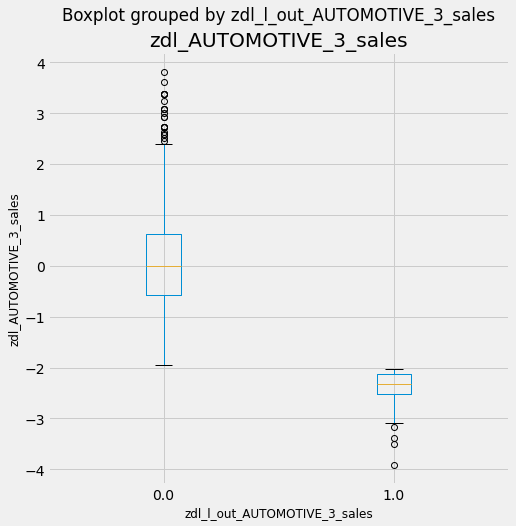

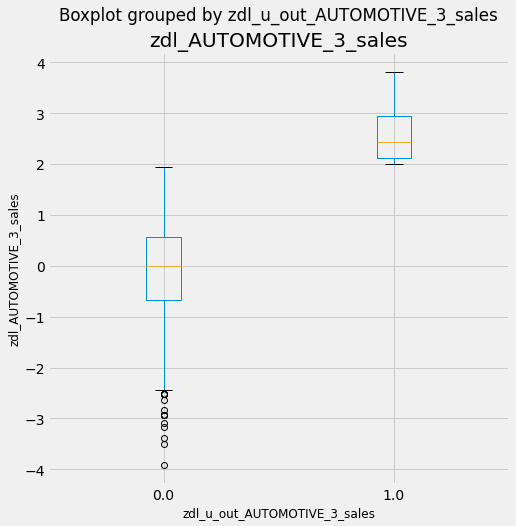

In [35]:
def qualiQuantiVariablesAnalysis (varName1, varName2):
    title = varName1 + " per " + varName2
    print("******** " + title + " ********")
    print(zdl_ts_train_validation[[varName1, varName2]].groupby(varName2).describe().T)
    boxVarS = zdl_ts_train_validation.boxplot(column=varName1,figsize=(8,8),vert=True, by=varName2)
    boxVarS.set_ylabel(varName1,fontsize=12)
    boxVarS.set_xlabel(varName2,fontsize=12)
qualiQuantiVariablesAnalysis(zdl_targetsNms[2], zdl_l_outlier_targetNms[2])
qualiQuantiVariablesAnalysis(zdl_targetsNms[2], zdl_u_outlier_targetNms[2])


### Calendar Features Graphics

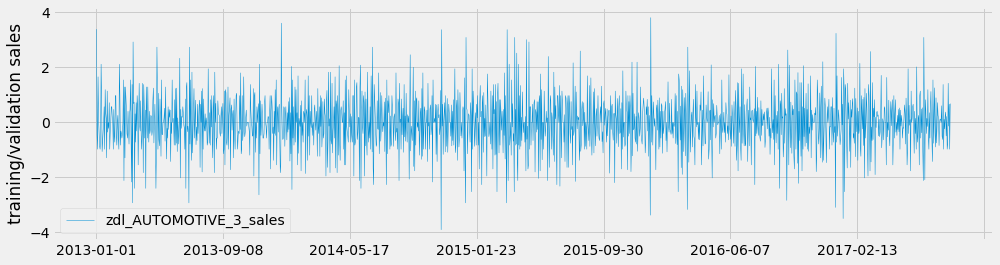

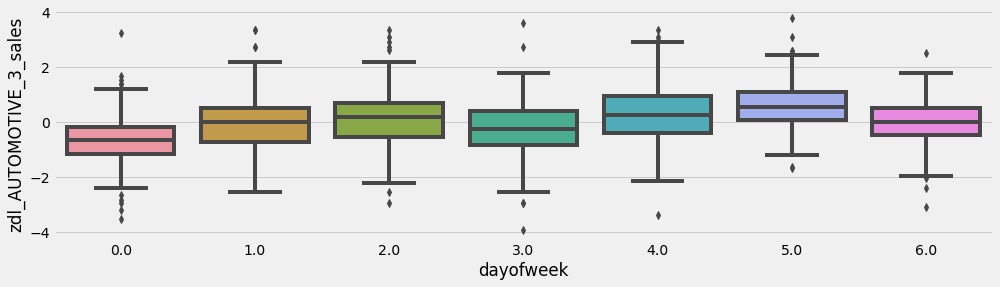

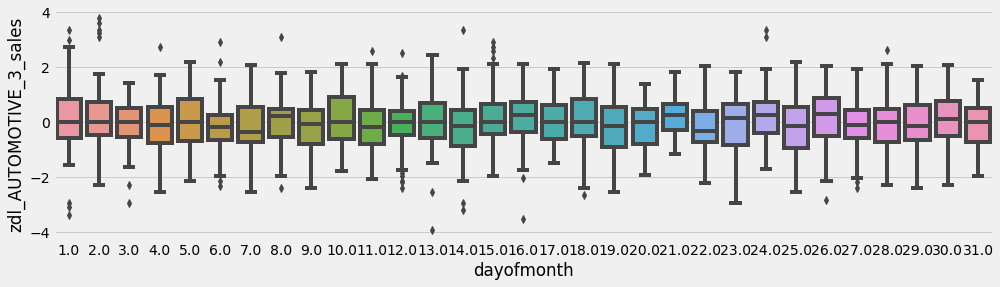

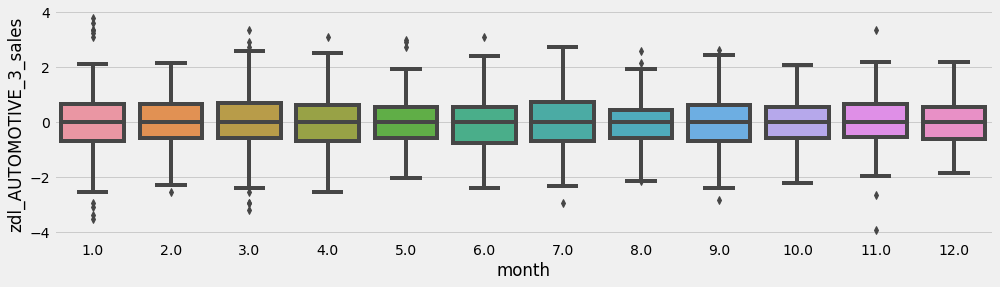

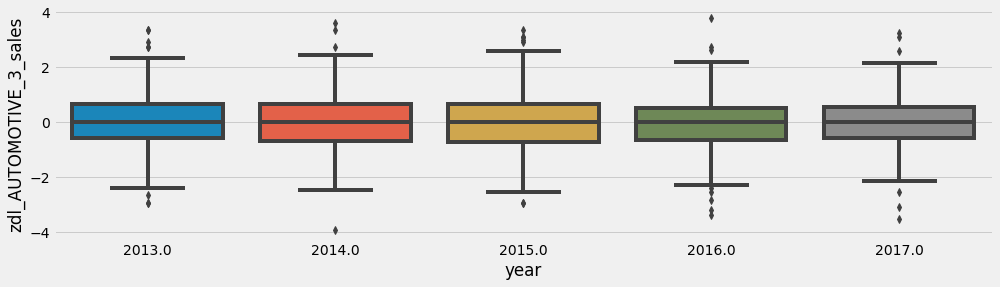

In [36]:
zdl_ts_train_validation[zdl_targetsNms[2]].plot(style='-',
                                          figsize=(15, 4),
                                          color=color_palette[:1],
                                          ylabel='training/validation sales',
                                          legend=zdl_targetsNms[2],
                                          linewidth=.5)
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(data=zdl_ts_train_validation, x='dayofweek', y=zdl_targetsNms[2])
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(data=zdl_ts_train_validation, x='dayofmonth', y=zdl_targetsNms[2])
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(data=zdl_ts_train_validation, x='month', y=zdl_targetsNms[2])
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(data=zdl_ts_train_validation, x='year', y=zdl_targetsNms[2])
plt.show()

### Lag Features Graphics

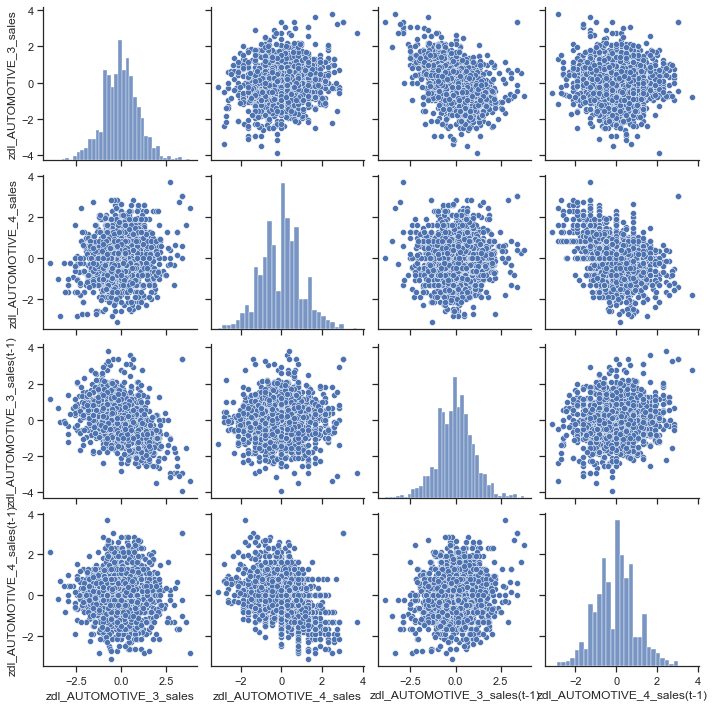

In [37]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(zdl_ts_train_validation[zdl_targetsNms[2:4] + [(targetNm + '(t-1)') for targetNm in zdl_targetsNms[2:4]]])
plt.show()

In [38]:
zdl_ts_train_validation[zdl_targetsNms].head(2)

,zdl_AUTOMOTIVE_1_sales,zdl_AUTOMOTIVE_2_sales,zdl_AUTOMOTIVE_3_sales,zdl_AUTOMOTIVE_4_sales,zdl_AUTOMOTIVE_5_sales,zdl_AUTOMOTIVE_6_sales,zdl_AUTOMOTIVE_7_sales,zdl_AUTOMOTIVE_8_sales,zdl_AUTOMOTIVE_9_sales,zdl_AUTOMOTIVE_10_sales,...,zdl_SEAFOOD_45_sales,zdl_SEAFOOD_46_sales,zdl_SEAFOOD_47_sales,zdl_SEAFOOD_48_sales,zdl_SEAFOOD_49_sales,zdl_SEAFOOD_50_sales,zdl_SEAFOOD_51_sales,zdl_SEAFOOD_52_sales,zdl_SEAFOOD_53_sales,zdl_SEAFOOD_54_sales
2013-01-01,1.222822,2.757599,3.372896,3.037553,2.702279,1.715303,2.441822,2.472943,2.302831,1.607483,...,8.254708,7.715093,9.657629,6.232829,8.384009,7.330135,8.769197,-0.006697,-0.001473,1.629224
2013-01-02,1.222822,2.757599,3.372896,3.037553,2.702279,1.715303,2.441822,2.472943,2.302831,1.607483,...,8.254708,7.715093,9.657629,6.232829,8.384009,7.330135,8.769197,-0.006697,-0.001473,1.629224
